In [1]:
import os
import glob
import json
import random
import datetime
import re
import cv2
import math
from typing import List, Optional, Dict, Any, Tuple

import numpy as np
from pathlib import Path

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, IterableDataset, TensorDataset
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

from scipy.stats import ttest_ind

from captum.concept import TCAV, Concept, Classifier
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients
from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str


from model.model import Net
from tools import utils, plotting, metrics, model_io, tcav, data


In [2]:
def transform(img):

    return transforms.Compose(
        [
            transforms.Resize(128),
            transforms.CenterCrop(128),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ]
    )(img)

In [3]:
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("L")
    return transform(img)


def load_image_tensors(class_name, root_path='data/concepts', transform=True):
    path = os.path.join(root_path, class_name)

    patterns = ('*.png', '*.jpg', '*.jpeg', '*.bmp')
    filenames = []
    for pat in patterns:
        filenames.extend(glob.glob(os.path.join(path, pat)))

    if not filenames:
        print(f"[load_image_tensors] no files under: {os.path.abspath(path)}")

    images = []
    for filename in sorted(filenames):
        img = Image.open(filename).convert('L')
        images.append(transform(img) if callable(transform) else img)
    return images


In [4]:
def assemble_concept(name, id, concepts_path="data\concepts"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)

In [5]:
concepts_path = ".\data\concepts"

circle_full        = assemble_concept("circle_full", 0, concepts_path=concepts_path)
circle_half_bottom = assemble_concept("circle_half_bottom", 1, concepts_path=concepts_path)
circle_half_left   = assemble_concept("circle_half_left", 2, concepts_path=concepts_path)
circle_half_right  = assemble_concept("circle_half_right", 3, concepts_path=concepts_path)
circle_half_top    = assemble_concept("circle_half_top", 4, concepts_path=concepts_path)

circle_quarter_bl  = assemble_concept("circle_quarter_bl", 5, concepts_path=concepts_path)
circle_quarter_br  = assemble_concept("circle_quarter_br", 6, concepts_path=concepts_path)
circle_quarter_tl  = assemble_concept("circle_quarter_tl", 7, concepts_path=concepts_path)
circle_quarter_tr  = assemble_concept("circle_quarter_tr", 8, concepts_path=concepts_path)

cross_arm_bottom   = assemble_concept("cross_arm_bottom", 9, concepts_path=concepts_path)
cross_arm_left     = assemble_concept("cross_arm_left", 10, concepts_path=concepts_path)
cross_arm_right    = assemble_concept("cross_arm_right", 11, concepts_path=concepts_path)
cross_arm_top      = assemble_concept("cross_arm_top", 12, concepts_path=concepts_path)
cross_arm_horizontal = assemble_concept("cross_arm_horizontal", 13, concepts_path=concepts_path)
cross_arm_vertical   = assemble_concept("cross_arm_vertical", 14, concepts_path=concepts_path)
cross_full         = assemble_concept("cross_full", 15, concepts_path=concepts_path)

random_pool        = assemble_concept("random_pool", 16, concepts_path=concepts_path)
random_pool_2        = assemble_concept("random_pool_2", 17, concepts_path=concepts_path)

square_corner_bl   = assemble_concept("square_corner_bl", 18, concepts_path=concepts_path)
square_corner_br   = assemble_concept("square_corner_br", 19, concepts_path=concepts_path)
square_corner_tl   = assemble_concept("square_corner_tl", 20, concepts_path=concepts_path)
square_corner_tr   = assemble_concept("square_corner_tr", 21, concepts_path=concepts_path)

square_edge_bottom = assemble_concept("square_edge_bottom", 22, concepts_path=concepts_path)
square_edge_left   = assemble_concept("square_edge_left", 23, concepts_path=concepts_path)
square_edge_right  = assemble_concept("square_edge_right", 24, concepts_path=concepts_path)
square_edge_top    = assemble_concept("square_edge_top", 25, concepts_path=concepts_path)

square_full        = assemble_concept("square_full", 26, concepts_path=concepts_path)
square_half_bottom = assemble_concept("square_half_bottom", 27, concepts_path=concepts_path)
square_half_left   = assemble_concept("square_half_left", 28, concepts_path=concepts_path)
square_half_right  = assemble_concept("square_half_right", 29, concepts_path=concepts_path)
square_half_top    = assemble_concept("square_half_top", 30, concepts_path=concepts_path)

ALL_CONCEPTS = [
    circle_full,
    circle_half_bottom, circle_half_left, circle_half_right, circle_half_top,
    circle_quarter_bl, circle_quarter_br, circle_quarter_tl, circle_quarter_tr,
    cross_arm_bottom, cross_arm_left, cross_arm_right, cross_arm_top,
    cross_arm_horizontal, cross_arm_vertical, cross_full,
    square_corner_bl, square_corner_br, square_corner_tl, square_corner_tr,
    square_edge_bottom, square_edge_left, square_edge_right, square_edge_top,
    square_full, square_half_bottom, square_half_left, square_half_right, square_half_top,
]

RANDOM_POOL = [random_pool, random_pool_2]

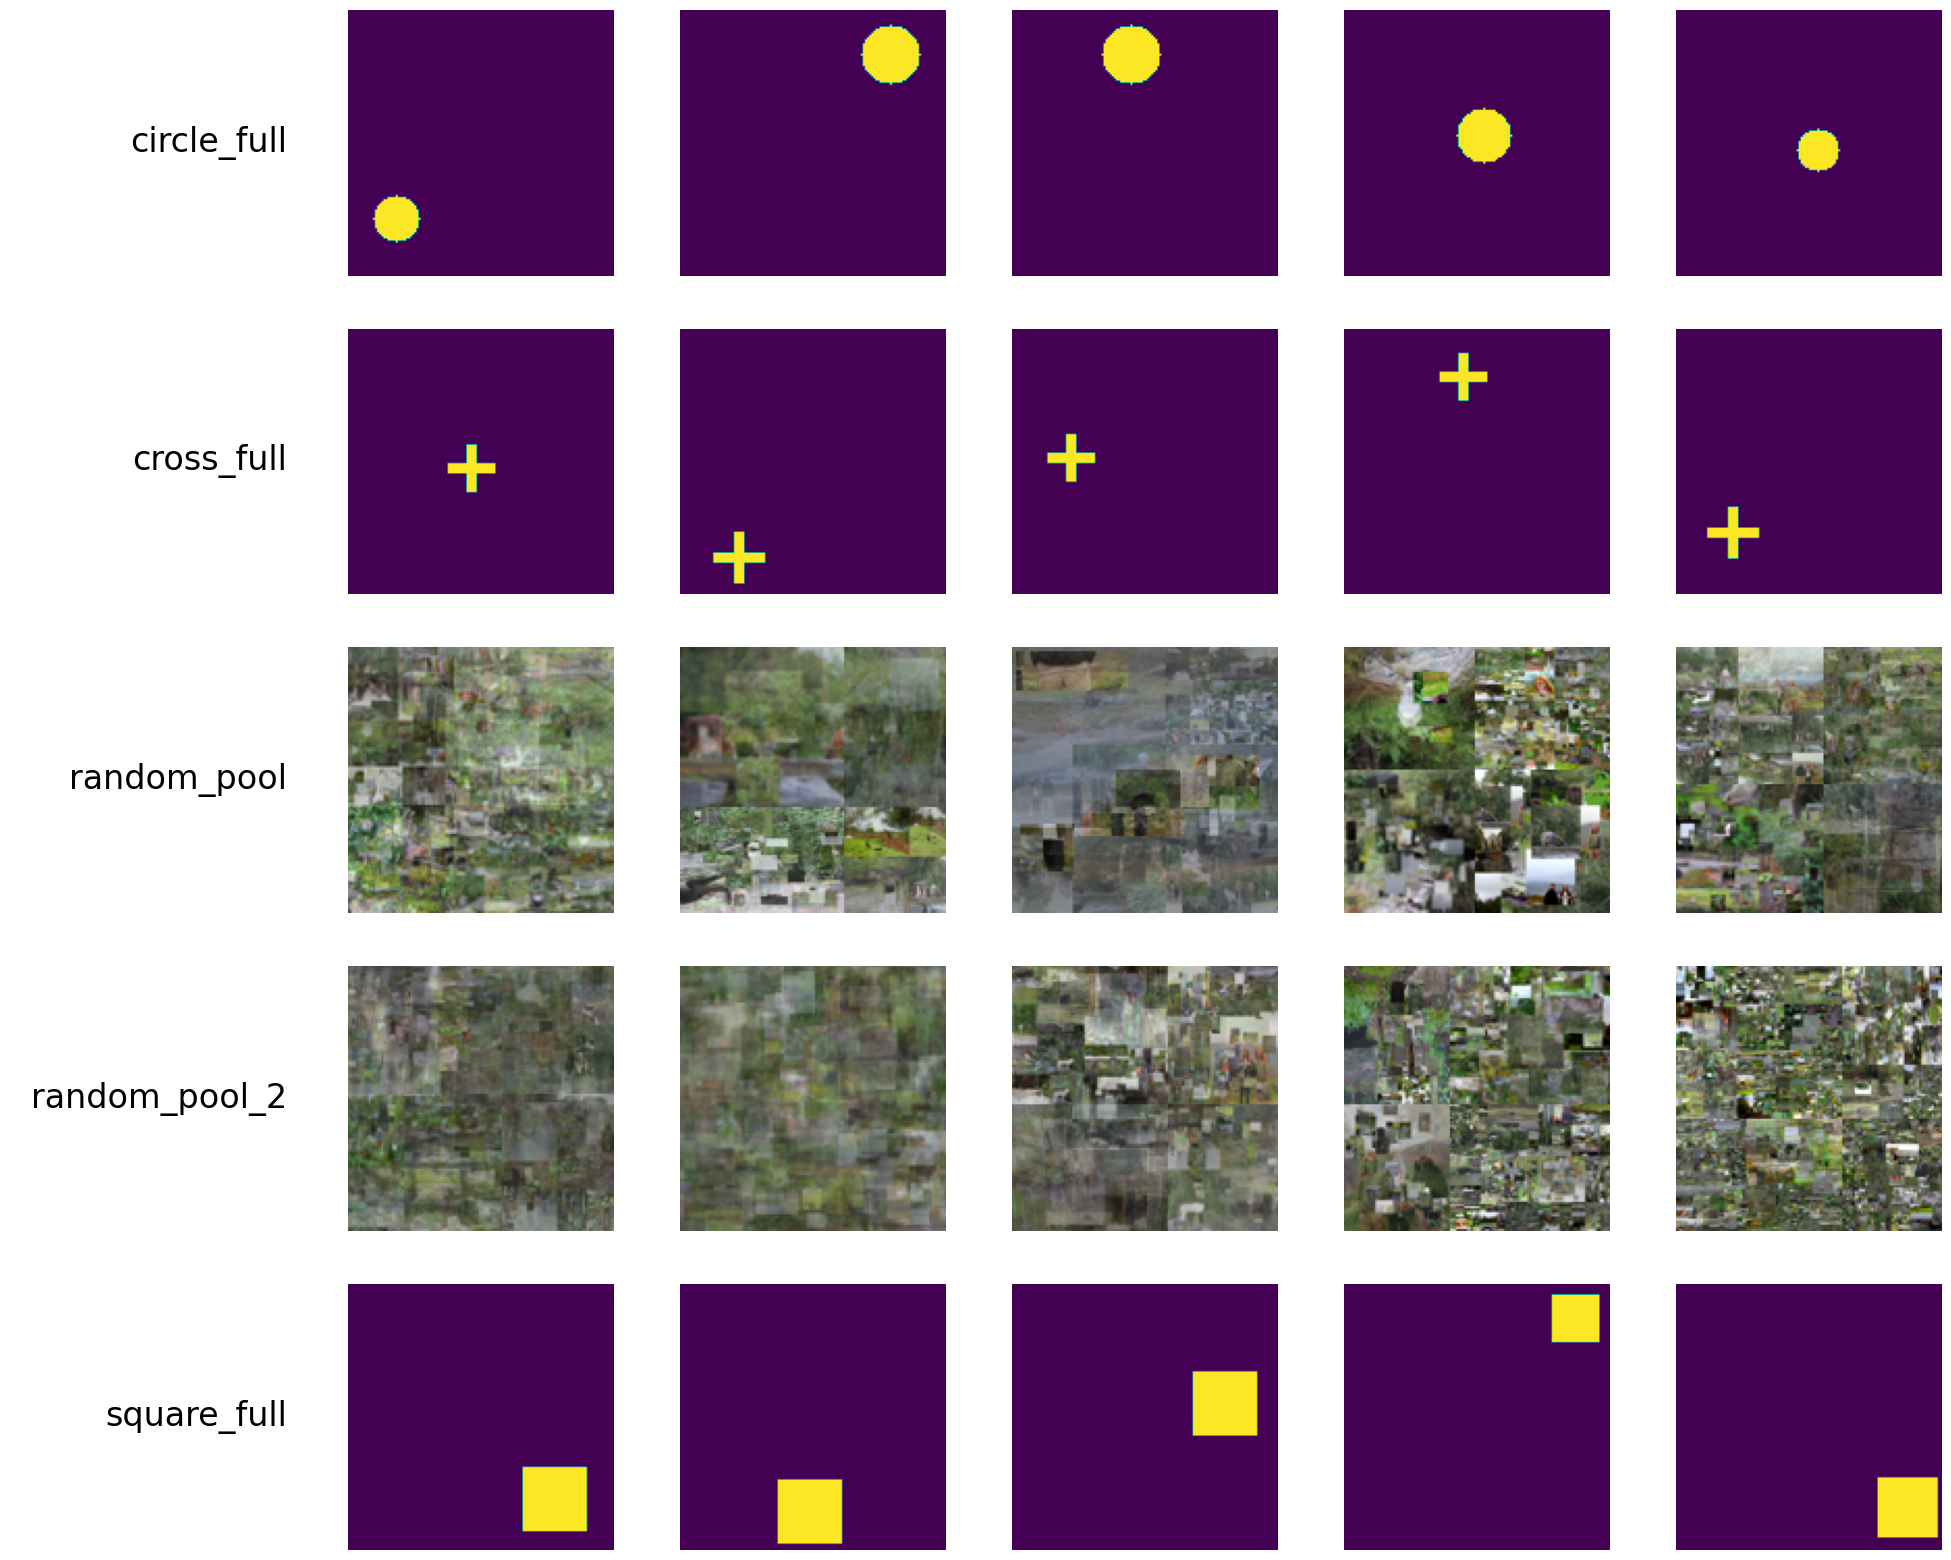

In [6]:
n_figs = 5
n_concepts = 5

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([circle_full, cross_full, random_pool, random_pool_2, square_full]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

In [12]:
DEVICE = torch.device("cpu")
CKPT   = Path("weights\pesos.pt")

def _load_state_dict(ckpt_path: Path) -> dict:
    obj = torch.load(ckpt_path, map_location="cpu")
    if isinstance(obj, dict) and ("state_dict" in obj or "model_state_dict" in obj):
        sd = obj.get("state_dict", obj.get("model_state_dict"))
    else:
        sd = obj
    sd = { (k[7:] if k.startswith("module.") else k): v for k, v in sd.items() }
    return sd

sd = _load_state_dict(CKPT)

in_channels = sd["conv1.weight"].shape[1]                 
try:
    num_classes = sd["fc4.weight"].shape[0]               
except KeyError:
    fc_weights = [(k, v) for k, v in sd.items() if k.endswith(".weight") and v.ndim == 2]
    assert fc_weights, "Couldn't infer num_classes from checkpoint."
    num_classes = fc_weights[-1][1].shape[0]

model = Net(numChannels=in_channels, classes=num_classes, size_img=128)
model.load_state_dict(sd, strict=True)
model.to(DEVICE).eval()

print(f"[OK] Loaded Net(in_channels={in_channels}, classes={num_classes}) on {DEVICE}")


[OK] Loaded Net(in_channels=1, classes=1) on cpu


C:\Users\Dylan\AppData\Local\Temp\ipykernel_26620\2646938786.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(ckpt_path, map_location="cpu")


In [13]:
LAYER_NAMES = ["relu3", "relu4", "relu5", "fc3"]
mytcav = TCAV(model=model,
              layers=LAYER_NAMES,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))

In [14]:
experimental_set_rand = [[cross_full, random_pool], [cross_full, random_pool_2]]

In [15]:
experimental_set_rand = [[cross_full, random_pool], [cross_full, random_pool_2]]

In [16]:
cross_set = load_image_tensors("cross_full", transform=False)

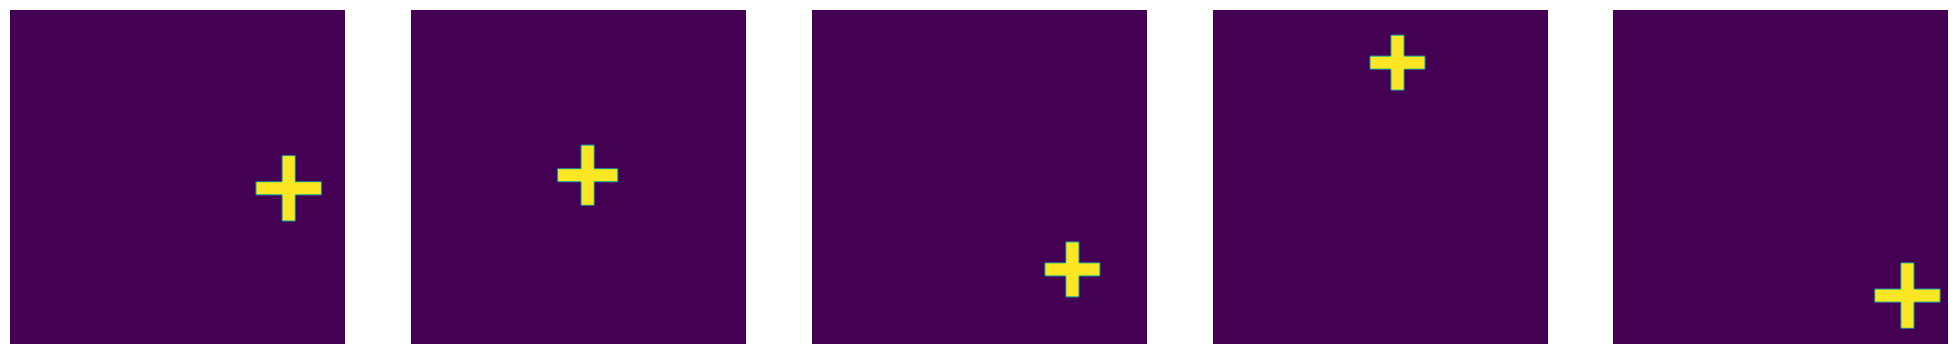

In [13]:
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(cross_set[40])
axs[1].imshow(cross_set[41])
axs[2].imshow(cross_set[34])
axs[3].imshow(cross_set[31])
axs[4].imshow(cross_set[30])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()

In [17]:
cross_tensors = torch.stack([transform(img) for img in cross_set])
experimental_set_rand

[[Concept(15, 'cross_full'), Concept(16, 'random_pool')],
 [Concept(15, 'cross_full'), Concept(17, 'random_pool_2')]]

In [18]:
IMAGE_PATH   = r"C:/Users/Dylan/Desktop/TCAV Captum/data/aixi_shape/val/00106.png"  
IMG_SIZE     = 128
IMG_CHANNELS = 1        
DEVICE       = "cpu"    

if IMG_CHANNELS == 1:
    tfm = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),                 
        
    ])
else:
    tfm = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        
    ])

img = Image.open(IMAGE_PATH).convert("L" if IMG_CHANNELS == 1 else "RGB")
x_local = tfm(img).unsqueeze(0).to(DEVICE) 
print("x_local shape:", tuple(x_local.shape))

with torch.no_grad():
    logits = model(x_local)
    if logits.ndim == 2:                      
        TARGET = int(logits.argmax(dim=1).item())
    elif logits.ndim == 1:                    
        TARGET = int((logits > 0).long().item()) 
    else:
        raise RuntimeError(f"Unexpected logits shape: {tuple(logits.shape)}")

print("Chosen TARGET class:", TARGET)


x_local shape: (1, 1, 128, 128)
Chosen TARGET class: 0


In [19]:
scores_local = mytcav.interpret(
    inputs=x_local,
    experimental_sets=experimental_set_rand,   # reuse the same Concept instances!
    target=1,
    processes=0,                           # Windows-friendly, avoids multiprocessing issues
    n_steps=8,
    internal_batch_size=1,
)

C:\Users\Dylan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\captum\_utils\av.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues rela

In [27]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(LAYER_NAMES))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(LAYER_NAMES))])
        _ax.set_xticklabels(LAYER_NAMES, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

def plot_tcav_scores_vertical(experimental_sets, tcav_scores, layer_names=None):
    import numpy as np
    import matplotlib.pyplot as plt

    layers = layer_names or LAYER_NAMES
    n_sets = len(experimental_sets)

    
    fig, axes = plt.subplots(n_sets, 1, figsize=(25, 6 * n_sets), constrained_layout=True)
    if n_sets == 1:
        axes = [axes]  

    
    for idx_es, concepts in enumerate(experimental_sets):
        ax = axes[idx_es]

        
        x = np.arange(len(layers))
        n_concepts = len(concepts)
        bar_width = 0.8 / n_concepts

        
        offsets = (np.arange(n_concepts) - (n_concepts - 1) / 2.0) * bar_width

        concepts_key = concepts_to_str(concepts)  

        for i in range(n_concepts):
            
            vals = [format_float(tcav_scores[concepts_key][layer]['sign_count'][i])
                    for layer in layers]
            ax.bar(x + offsets[i], vals, width=bar_width, edgecolor='white',
                   label=concepts[i].name)

        ax.set_title(f"Set {idx_es}", fontweight='bold', fontsize=16)
        ax.set_xticks(x)
        ax.set_xticklabels(layers, fontsize=12, rotation=0)
        ax.set_ylabel('TCAV sign count', fontsize=12)
        ax.legend(fontsize=12)
        ax.grid(axis='y', linestyle=':', alpha=0.4)

    plt.show()

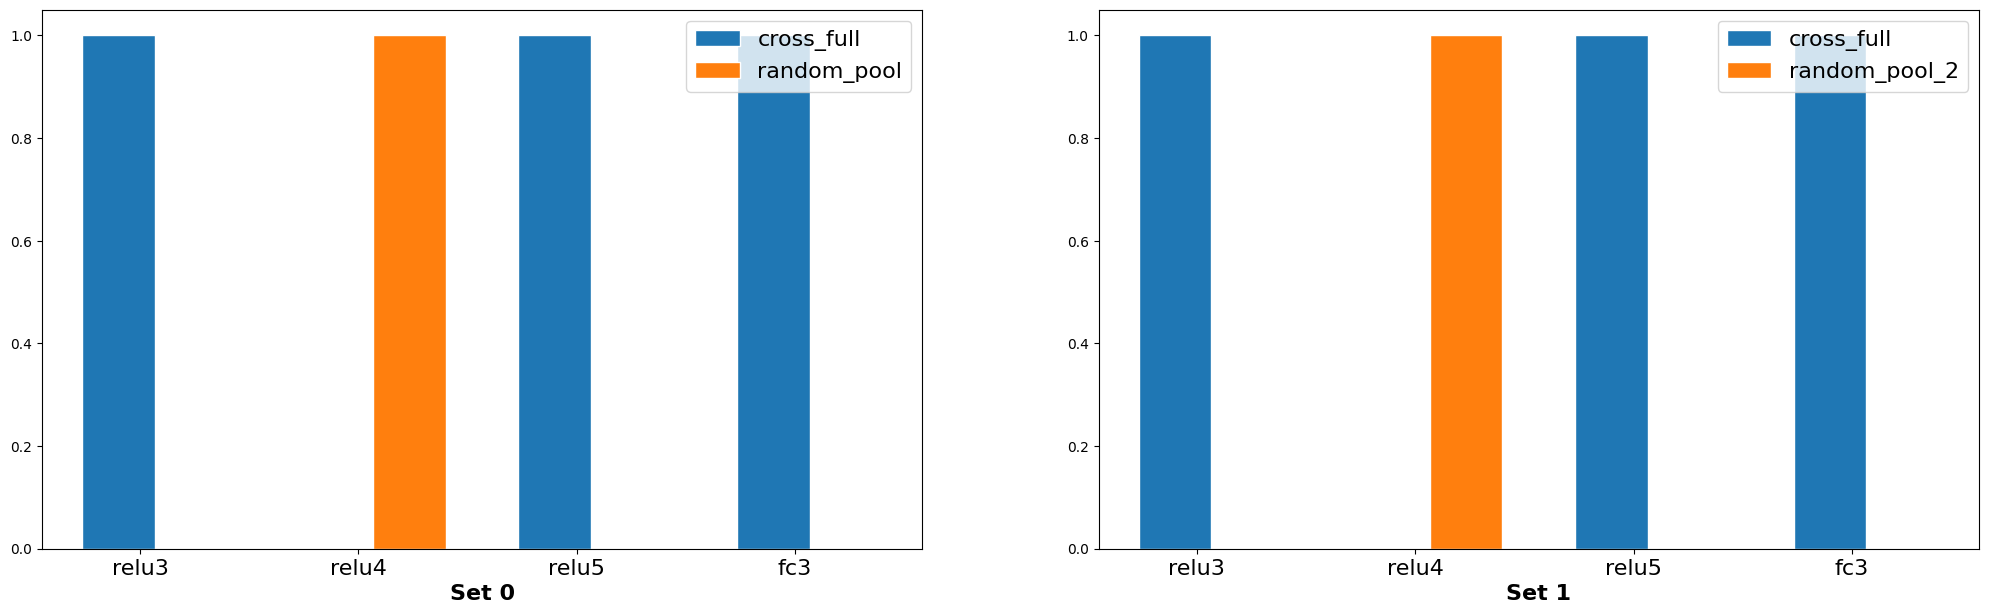

In [23]:
plot_tcav_scores(experimental_set_rand, scores_local)

In [20]:
for name, mod in model.named_modules():
    print(f"{name:15s} {mod.__class__.__name__}")

                Net
conv1           Conv2d
relu1           ReLU
bn1             BatchNorm2d
maxpool1        MaxPool2d
conv2           Conv2d
relu2           ReLU
bn2             BatchNorm2d
maxpool2        MaxPool2d
conv3           Conv2d
relu3           ReLU
bn3             BatchNorm2d
maxpool3        MaxPool2d
conv4           Conv2d
relu4           ReLU
bn4             BatchNorm2d
maxpool4        MaxPool2d
conv5           Conv2d
relu5           ReLU
bn5             BatchNorm2d
maxpool5        MaxPool2d
fc1             Linear
dropout1        Dropout
relu6           ReLU
fc2             Linear
dropout2        Dropout
relu7           ReLU
fc3             Linear
dropout3        Dropout
relu8           ReLU
fc4             Linear


In [25]:
DEVICE = torch.device("cpu")            
model = model.to(DEVICE).eval()
x_local = x_local.to(DEVICE)

LAYER_NAMES = ['conv3', 'relu3', 'conv4', 'relu4', 'fc3']  


available = {n for n, _ in model.named_modules()}
LAYER_NAMES = [n for n in LAYER_NAMES if n in available]

mytcav = TCAV(
    model=model,
    layers=LAYER_NAMES,
    layer_attr_method=LayerIntegratedGradients(
                model, None, multiply_by_inputs=False),
)

scores_local = mytcav.interpret(
    inputs=x_local,
    experimental_sets=experimental_set_rand,  
    target=0,                   
    processes=0,
    n_steps=8,
    internal_batch_size=1,
)

C:\Users\Dylan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\captum\concept\_core\tcav.py:325: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  self.classifier = DefaultClassifier()
C:\Users\Dylan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\captum\concept\_core\cav.py:193: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future rel

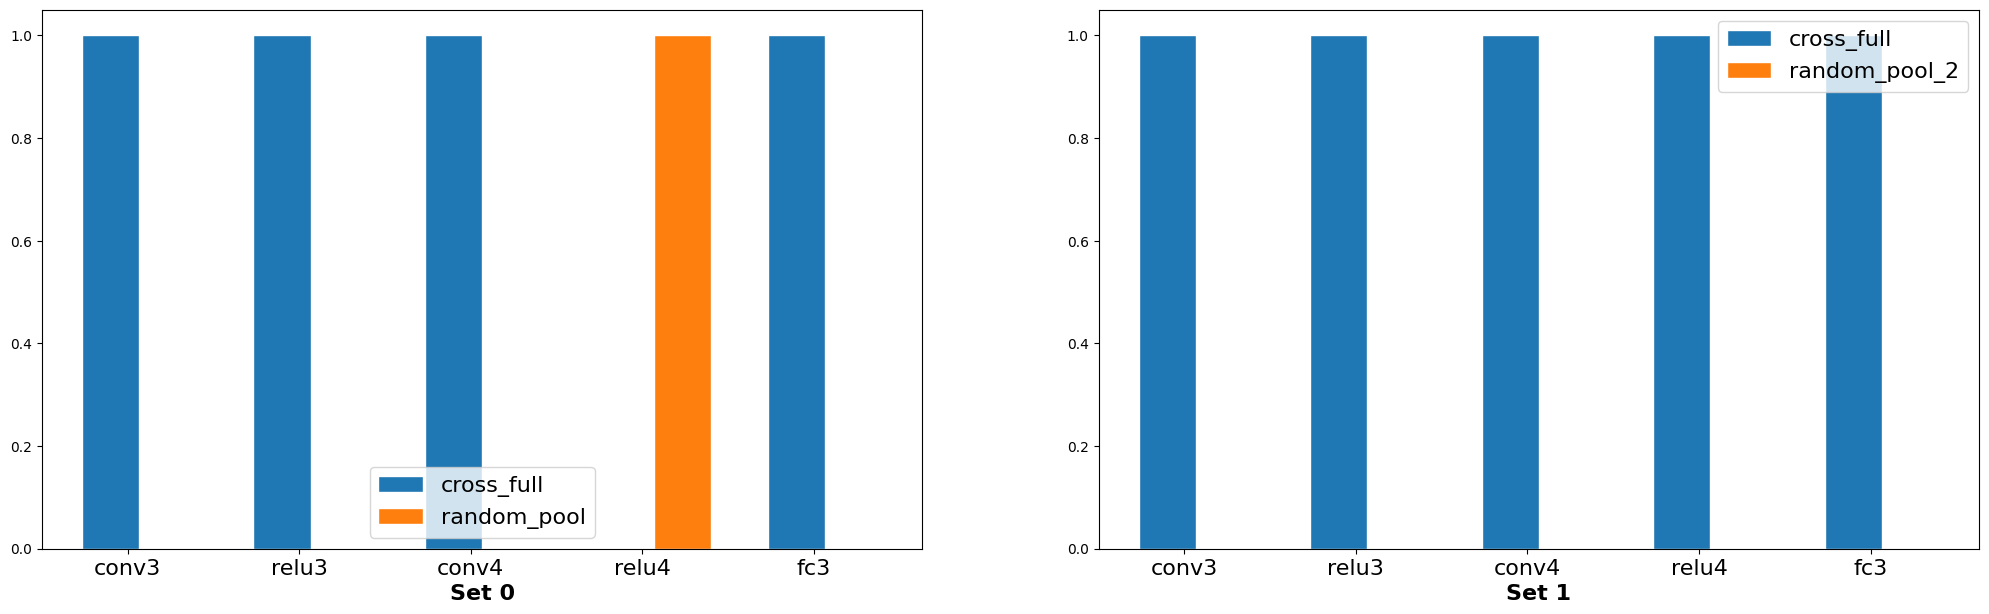

In [28]:
plot_tcav_scores(experimental_set_rand, scores_local)

Test

In [29]:
from torchvision.transforms import InterpolationMode

DEVICE = torch.device("cpu")
IMG_SIZE = 128

tfm = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    # transforms.Normalize([0.5],[0.5])  # ← uncomment if used in training
])

img = Image.open(IMAGE_PATH).convert("L")
x_local = tfm(img).unsqueeze(0).to(DEVICE)  # [1,1,128,128]
model = model.to(DEVICE).eval()

print("x_local shape:", tuple(x_local.shape))  # (1,1,128,128)
with torch.no_grad():
    out = model(x_local)
print("model output shape:", tuple(out.shape))  # e.g., (1,) or (1,1) → single-logit

x_local shape: (1, 1, 128, 128)
model output shape: (1, 1)
